In [1]:
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import fwi
import torch
import time 
import matplotlib.pylab  as plt
from util import * 
import deepwave
from scipy import signal
from skimage.transform import resize, rescale 

# ========================== Functions  ============================== #


def freq_filter(freq, wavelet,btype,fs):
    """
    Filter frequency

    Parameters
    ----------
    freq : :obj:`int` or `array in case of bandpass `
    Cut-off frequency
    wavelet : :obj:`torch.Tensor`
    Tensor of wavelet
    btype : obj: 'str'
    Filter type  
    dt : :obj:`float32`
    Time sampling
    Returns
    -------
    : :obj:`torch.Tensor`
    Tensor of highpass frequency wavelet
    """


    ''' AA: Added 6/fs to prevent frequency leak. 
    The argument (2 * freq /fs) is from the definition of the filter signal.butter, 
    chek the value of Wn in the definition of signal.butter. 
    I manually added/subtract 6/fs to prevent leak. The number was selected based on trial and error and plotting the spectrum
    '''
    if btype == 'hp': sos = signal.butter(4,  6/fs + 2 * freq /fs, 'hp', output='sos') 
    if btype == 'lp': sos = signal.butter(4,   2 * freq /fs - 6/fs , 'lp', output='sos') 
    if btype == 'bp': sos = signal.butter(4,  [2/fs + 2 * freq[0] /fs,  2 * freq[1] /fs - 2/fs ], 
                            'bp', output='sos') 
    return torch.tensor( signal.sosfiltfilt(sos, wavelet,axis=0).copy(),dtype=torch.float32)


def mask(m,value):
    """
    Return a mask for the model (m) using the (value)
    """
#     msk = m > value
#     msk = msk.astype(int)
    
    msk = np.ones_like(m)
    for ix in range(m.shape[1]):
        for iz in range (m.shape[0]):
            if m[iz,ix]<=value : 
                msk[iz,ix] = 0
            else: break
    
    return msk
    
# =================================================================== #

In [2]:
# ========================== Main  ============================== #

device = torch.device('cuda:0')

# mtrue = mtrue.T
# ============================ setting parameters =============================#

# Define the model and achuisition parameters
par = {     'nx':1685,   'dx':0.02, 'ox':0,
            'nz':201,   'dz':0.02, 'oz':0,
#             'ns':400,   'ds':0.0825,   'osou':0,  'sz':0.06,
            'ns':100,   'ds':0.33,   'osou':0,  'sz':0.06,
            'nr':674,   'dr':0.04,  'orec':0,    'rz':0.06,
#             'nt':2500,  'dt':0.002,  'ot':0,
            'nt':1250,  'dt':0.004,  'ot':0,
#             'nt':625,  'dt':0.008,  'ot':0,
            'freq':10,
            'FWI_itr': 1000,
            'num_dims':2
      }


par['mxoffset']=6
par['nr'] = int((2 * par['mxoffset'])//(par['dr'])) +1  
# par['ds'] = np.round((par['nx']*par['dx'] - 2 * par['mxoffset']  )/par['ns'],3)
par['osou'] = 0
par['orec'] = par['osou'] - par['mxoffset']




    
fs = 1/par['dt'] # sampling frequency

par ['batch_size'] = 4
par ['num_batches'] = par['ns']//par ['batch_size'] 
 
# Don't change the below two lines 
num_sources_per_shot=1

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]

In [3]:
# ============================ I/O =============================#

# True model
path = './'
velocity_path = './velocity/'
# i/o files
vel_true =velocity_path+'bp_full_fixed.npy' # true model 


# Output parameter 

fwi_pass= 1
minF = 3
maxF = 7
TV_FLAG = False 
TV_ALPHA = 0
smth1 = 10
smth2 = 15

# fwi_pass= 1
# minF = 3
# maxF = 7
# TV_FLAG = True 
# TV_ALPHA = 0.01
# smth1 = 2
# smth2 = 5

inv_file=f"BPfull_1stinv_TV{TV_ALPHA}_offs{par['mxoffset']}_DomFreq{par['freq']}_MinFreq{minF}_MaxFre{maxF}_fwi{fwi_pass}_smth{smth1}-{smth2}"
output_file = velocity_path+inv_file+'temp2'
    
    
mtrue = np.load(vel_true)
# mtrue = mtrue.T




In [4]:
# ============================ Forward modelling =============================#
# convert to tensor

mtrue = torch.tensor(mtrue,dtype=torch.float32)
# initiate the fwi class
inversion = fwi.fwi(par,2)

# xr_corr = inversion.r_cor[:,:,1]
# xr_corr [xr_corr < 0 ] = 0
# xr_corr [xr_corr > (nx-1)*dx ] = (nx-1)*dx  # last point in the model 
# inversion.r_cor[:,:,1] =  xr_corr




In [5]:
wavel = inversion.Ricker(freq)  
data = torch.zeros((nt,ns,nr),dtype=torch.float32)
data = inversion.forward_modelling(mtrue,wavel.repeat(1,ns,num_sources_per_shot),device).cpu()


torch.cuda.empty_cache()


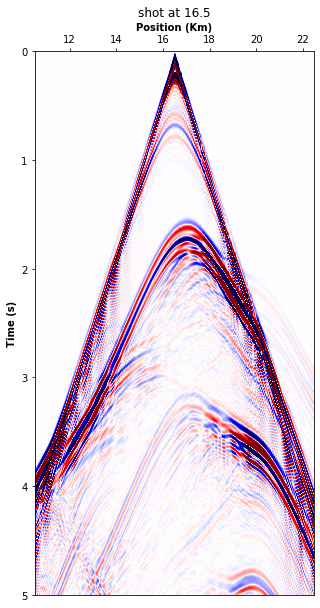

In [6]:
shot = 50
plt.figure(figsize=(5,10))
vmin, vmax = np.percentile(data[:,shot].cpu().numpy(), [2,98])
plt.imshow(data[:,shot,:],cmap='seismic',vmin=vmin,vmax=-vmin,
           extent=[inversion.r_cor[shot,0,1].numpy(),inversion.r_cor[shot,nr-1,1].numpy(),par['nt']*par['dt'],par['ot']])
plt.axis('tight')
plt.xlabel('Position (Km)',weight='heavy')
plt.ylabel('Time (s)',weight='heavy')
plt.title(f'shot at {inversion.s_cor[shot,0,1]}')
plt.gca().axes.get_xaxis().set_label_position('top')
plt.gca().axes.get_xaxis().tick_top()

In [7]:
# filter frequencies 
wavel_f = freq_filter(freq=[3,7],wavelet=wavel,btype='bp',fs=fs)
data_f = freq_filter(freq=[3,7],wavelet=data,btype='bp',fs=fs)




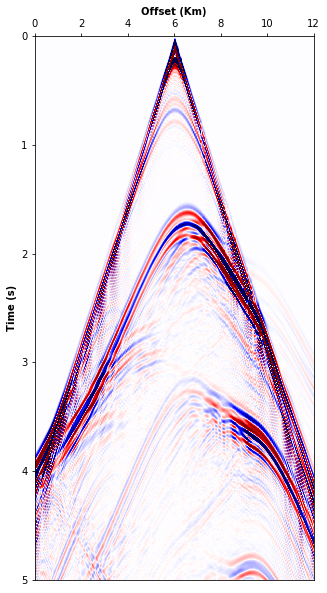

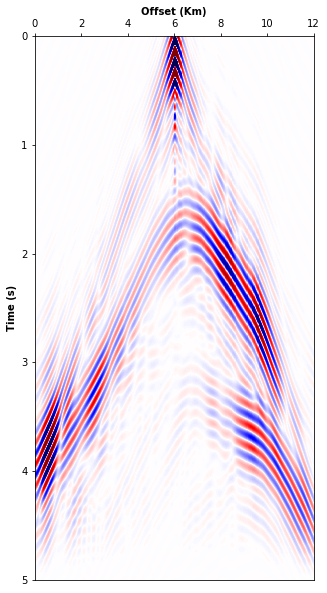

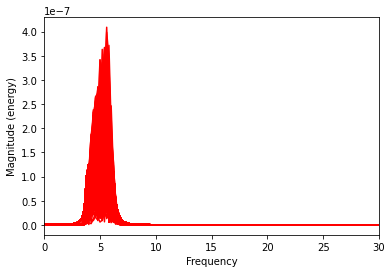

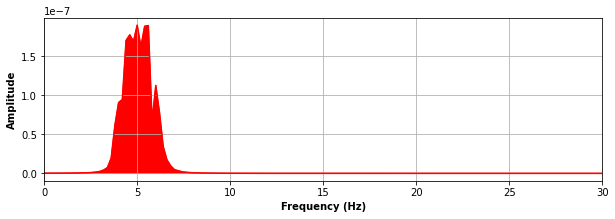

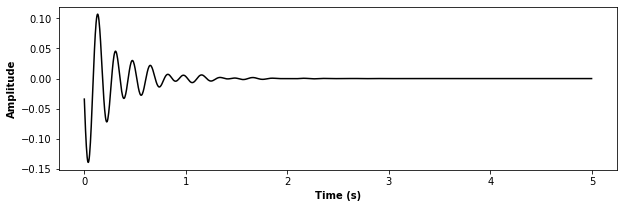

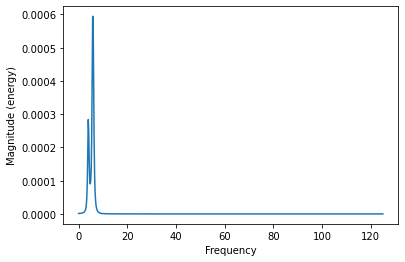

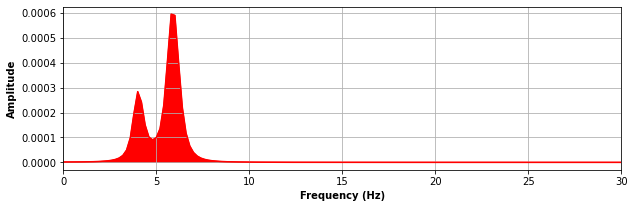

In [8]:
# ======================= Plotting Frequency Spectrum ============================= #

# Plot data 
plt.figure(figsize=(5,10))
vmin, vmax = np.percentile(data[:,0].cpu().numpy(), [2,98])
plt.imshow(data[:,int(ns//2),:],cmap='seismic',vmin=vmin,vmax=-vmin,extent=[0,par['dr']*par['nr'],par['nt']*par['dt'],par['ot']])
plt.axis('tight')
plt.xlabel('Offset (Km)',weight='heavy')
plt.ylabel('Time (s)',weight='heavy')
plt.gca().axes.get_xaxis().set_label_position('top')
plt.gca().axes.get_xaxis().tick_top()
plt.savefig('./Fig/shot',bbox_inches='tight')


plt.figure(figsize=(5,10))
vmin, vmax = np.percentile(data[:,0].cpu().numpy(), [2,98])
plt.imshow(data_f[:,int(ns//2),:],cmap='seismic',vmin=vmin,vmax=-vmin,extent=[0,par['dr']*par['nr'],par['nt']*par['dt'],par['ot']])
plt.axis('tight')
plt.xlabel('Offset (Km)',weight='heavy')
plt.ylabel('Time (s)',weight='heavy')
plt.gca().axes.get_xaxis().set_label_position('top')
plt.gca().axes.get_xaxis().tick_top()
plt.savefig('./Fig/shot_filter',bbox_inches='tight')
# Plotting shot spectrum
plt.figure()
YY = []
FF = []
for i in range(data.shape[2]):
    Y = plt.magnitude_spectrum(data_f[:,0,i].numpy().flatten(),Fs=fs,color='r')
    plt.xlim([0,30])
    YY.append(Y[0])
    FF.append(Y[1])
    # plt.fill_between(Y[1],Y[0],color='r')
YYY = np.array(YY)
FFF = np.array(FF)

plt.figure(figsize=(10,3))
plt.plot(FFF[0,:],np.average(YYY,axis=0),color='r')
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)',weight='heavy')
plt.ylabel('Amplitude',weight='heavy')
plt.fill_between(FFF[0,:],np.average(YYY,axis=0),color='r')
plt.grid(which='both')
plt.savefig('./Fig/shot_spectrum',bbox_inches='tight')




# Plotting wavelet and its spectrum 
wav = wavel_f.numpy()[:,-1]
plt.figure(figsize=(10,3))
plt.plot(np.arange(wav.shape[0])*dt,wav,color='k')
plt.xlabel('Time (s)',weight='heavy')
plt.ylabel('Amplitude',weight='heavy')
# plt.gca().axes.get_yaxis().set_visible(False)
plt.savefig('./Fig//wavelet',bbox_inches='tight')

plt.figure()
Y = plt.magnitude_spectrum(wav.flatten(),Fs=fs)
YY = Y[0]
FF = Y[1]

plt.figure(figsize=(10,3))
plt.plot(FF,YY,color='r')
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)',weight='heavy')
plt.ylabel('Amplitude',weight='heavy')
plt.fill_between(FF,YY,color='r')
plt.grid(which='both')
plt.savefig('./Fig/wavelet_frequency',bbox_inches='tight')

torch.Size([201, 1685])


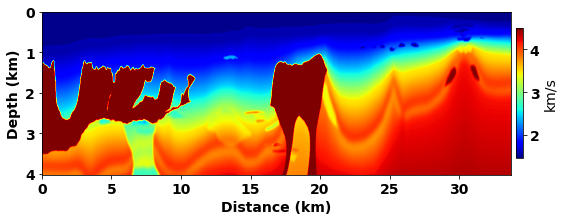

torch.Size([1250, 100, 300])


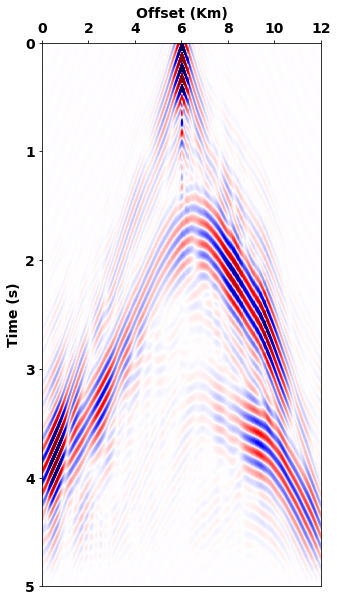

In [9]:
# ================ Plotting =============== # 
# Plot the true models and initial     
print(mtrue.shape)
Plot_model(mtrue,par)

print(data.shape)
plt.figure(figsize=(5,10))
vmin, vmax = np.percentile(data[:,0], [2,98])
plt.imshow(data_f[:,50,:],cmap='seismic',vmin=vmin,vmax=-vmin,extent=[0,par['dr']*par['nr'],par['nt']*par['dt'],par['ot']])
plt.axis('tight')
plt.xlabel('Offset (Km)',weight='heavy')
plt.ylabel('Time (s)',weight='heavy')
plt.gca().axes.get_xaxis().set_label_position('top')
plt.gca().axes.get_xaxis().tick_top()


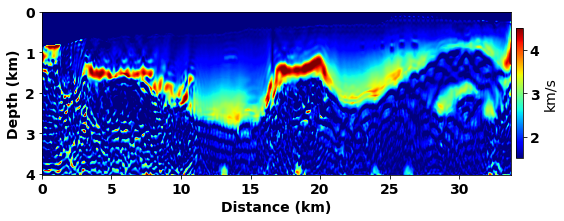

In [10]:
# ========================= Cretae initial model =================== # 
# mask 
msk = mask(mtrue.numpy(),1.5)

# bp_mean = np.nanmean(mtrue,axis=1)
# bp_mean = bp_mean.reshape(-1,1)
# minit =  np.repeat(bp_mean,nx,axis=1)
# minit = minit * msk
# minit[minit==0] = 1.5


# constant init 
# minit = msk.copy()
# minit = minit.astype(np.float32())
# for ix in range (nx):
#     iz = np.where(minit[:,ix] > 0)[0][0]
#     minit[iz:,ix]  = mtrue[iz,ix]
# minit [minit == 0] = 1.5


minit = './velocity/BPfull_1stinv_TV0_offs6_DomFreq10_MinFreq3_MaxFre7_fwi1_smth10-15temp.npy'
minit = np.load(minit)[-1]

Plot_model(minit,par)

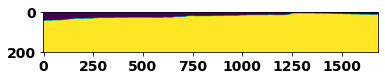

In [11]:
plt.imshow(msk)

In [12]:

# Convert to torch
minit = torch.tensor(minit,dtype=torch.float32)
data_f = torch.tensor(data_f,dtype=torch.float32)

wavel_f = torch.tensor(wavel_f,dtype=torch.float32)


/tmp/ipykernel_33526/2536936853.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_f = torch.tensor(data_f,dtype=torch.float32)
/tmp/ipykernel_33526/2536936853.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavel_f = torch.tensor(wavel_f,dtype=torch.float32)


In [13]:
# ======================= Saving data and wavelet ============================= #
# # %%
# data_save = data.clone().permute(1,2,0).numpy()
# save_3ddata(data_save,par,'./data_mod.rsf')
# save_1drsf(wavel.clone().numpy(),par,'./wavl.rsf')

Iteration:  0 Objective:  9.616360117058187e-12


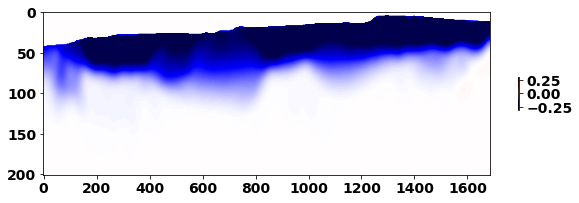

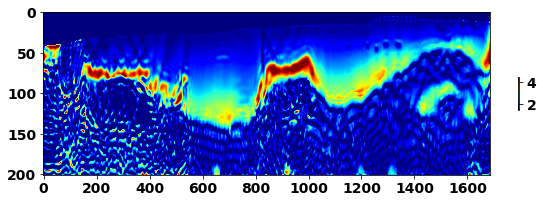

Iteration:  1 Objective:  8.387901105025991e-12
Iteration:  2 Objective:  8.378245932314302e-12
Iteration:  3 Objective:  8.42240161077687e-12
Iteration:  4 Objective:  8.293109878291724e-12
Iteration:  5 Objective:  8.191198614575582e-12


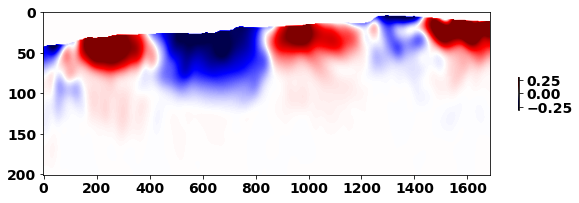

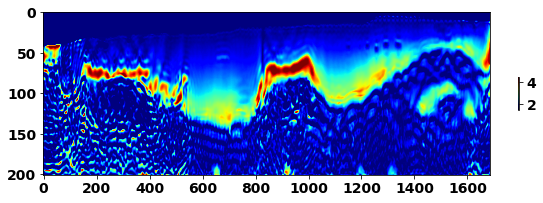

Iteration:  6 Objective:  8.207618558322277e-12
Iteration:  7 Objective:  8.225885738625399e-12
Iteration:  8 Objective:  8.194746584869878e-12
Iteration:  9 Objective:  8.155559832068865e-12
Iteration:  10 Objective:  8.151180549758816e-12


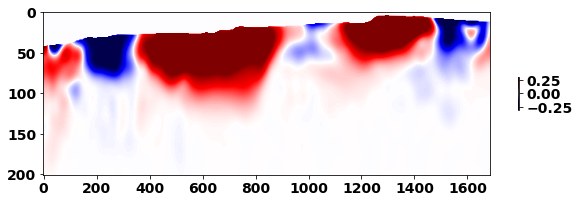

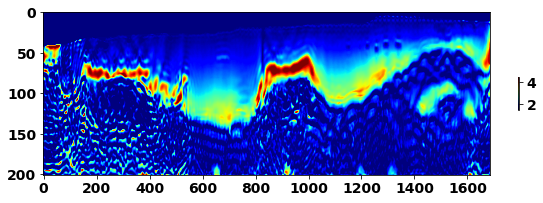

Iteration:  11 Objective:  8.147474313052391e-12
Iteration:  12 Objective:  8.137439235899463e-12
Iteration:  13 Objective:  8.126207335073382e-12
Iteration:  14 Objective:  8.113236401067689e-12
Iteration:  15 Objective:  8.113155221430024e-12


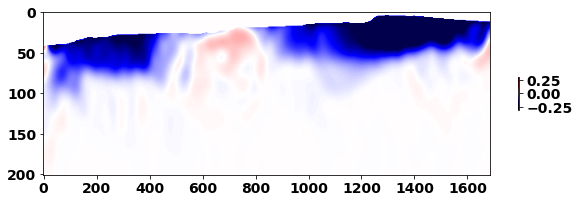

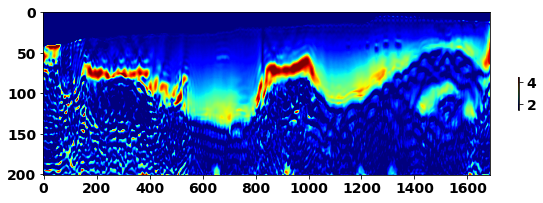

Iteration:  16 Objective:  8.115127439391884e-12
Iteration:  17 Objective:  8.112155993602807e-12
Iteration:  18 Objective:  8.10680350431768e-12
Iteration:  19 Objective:  8.11017103626542e-12
Iteration:  20 Objective:  8.108429970206735e-12


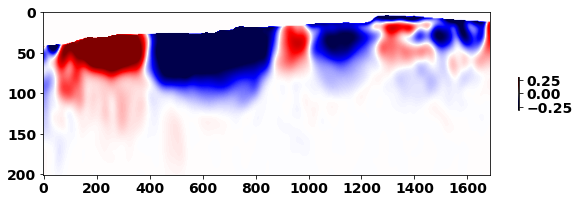

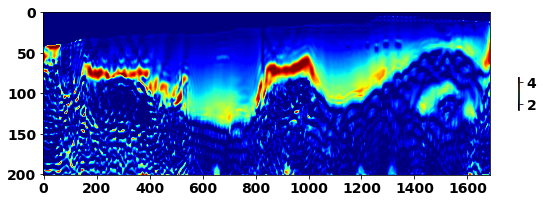

Iteration:  21 Objective:  8.103597003497609e-12
Reduce the smoothing from 10.0,15.0 to 5.0,7.5
Iteration:  22 Objective:  8.104145636901941e-12
Reduce the smoothing from 5.0,7.5 to 2.5,3.75
Iteration:  23 Objective:  8.104064565684493e-12
Reduce the smoothing from 2.5,3.75 to 1.25,1.875
Iteration:  24 Objective:  8.097362407324948e-12
Reduce the smoothing from 1.25,1.875 to 0.625,0.9375
Iteration:  25 Objective:  8.080384289194803e-12


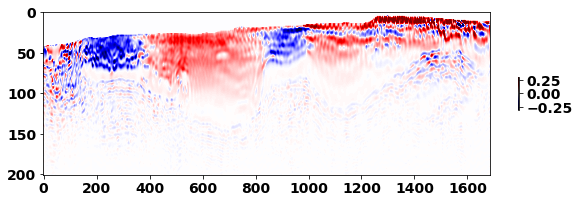

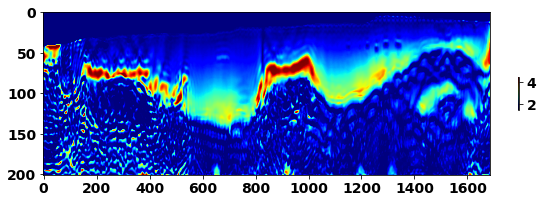

Iteration:  26 Objective:  8.055092806961636e-12
Iteration:  27 Objective:  8.023201948734876e-12
Iteration:  28 Objective:  7.987379854745846e-12
Iteration:  29 Objective:  7.95082039485931e-12
Iteration:  30 Objective:  7.91641071814543e-12


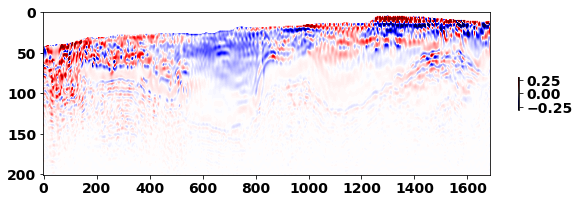

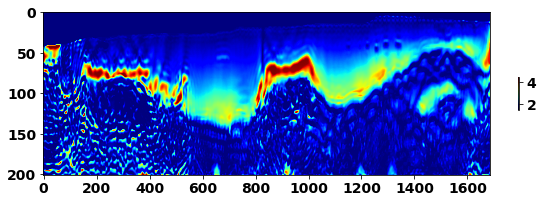

Iteration:  31 Objective:  7.886215484353802e-12
Iteration:  32 Objective:  7.858091212236892e-12
Iteration:  33 Objective:  7.82886499768945e-12
Iteration:  34 Objective:  7.79731005240078e-12
Iteration:  35 Objective:  7.765076857338057e-12


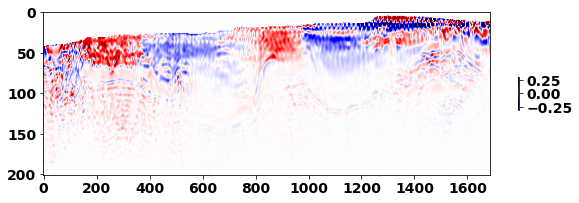

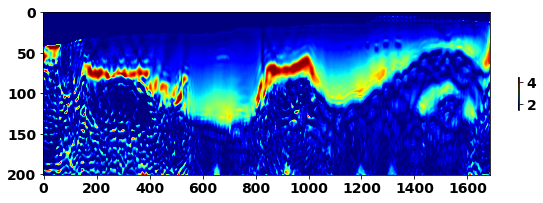

Iteration:  36 Objective:  7.736250062870959e-12
Iteration:  37 Objective:  7.711975968851398e-12
Iteration:  38 Objective:  7.690473244662509e-12
Iteration:  39 Objective:  7.669511605120326e-12
Iteration:  40 Objective:  7.648121177171452e-12


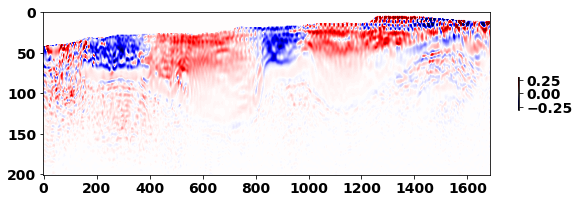

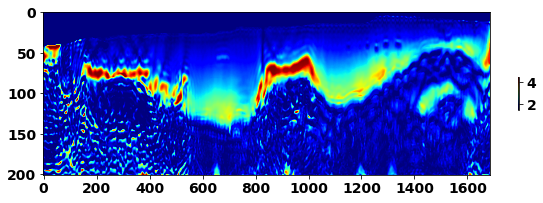

Iteration:  41 Objective:  7.626911553487367e-12
Iteration:  42 Objective:  7.607008135923111e-12
Iteration:  43 Objective:  7.588772289062774e-12
Iteration:  44 Objective:  7.571401594878499e-12
Iteration:  45 Objective:  7.554717810533129e-12


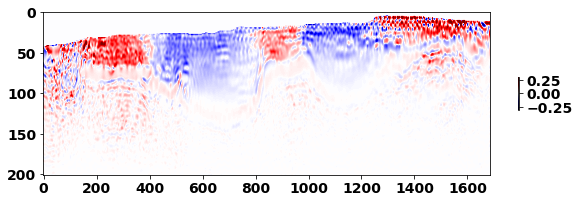

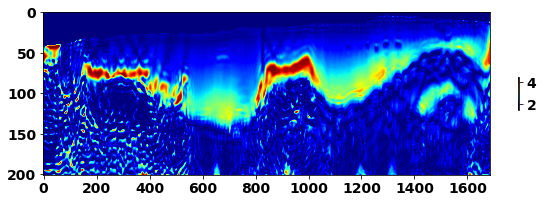

Iteration:  46 Objective:  7.539040613037222e-12
Iteration:  47 Objective:  7.524689638743753e-12
Iteration:  48 Objective:  7.511769431847205e-12
Iteration:  49 Objective:  7.499804732325269e-12
Iteration:  50 Objective:  7.48794869696607e-12


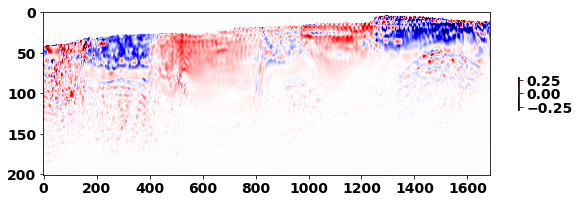

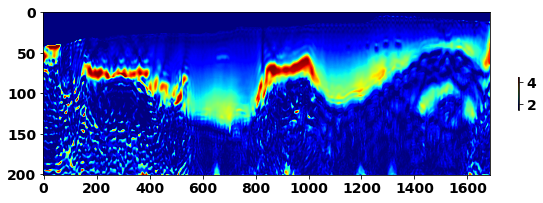

Iteration:  51 Objective:  7.476059620545664e-12
Iteration:  52 Objective:  7.46497607923436e-12
Iteration:  53 Objective:  7.455009672736532e-12
Iteration:  54 Objective:  7.44560164391006e-12
Iteration:  55 Objective:  7.436387307801703e-12


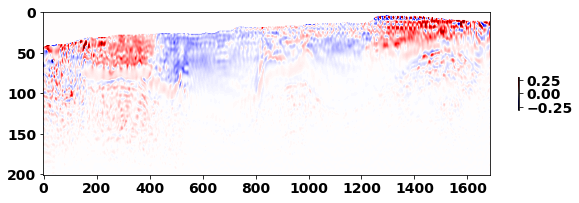

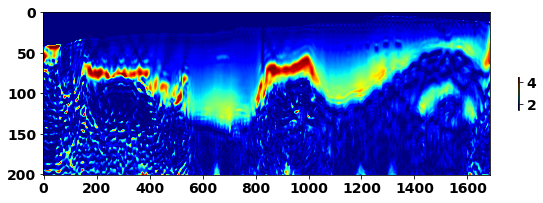

Iteration:  56 Objective:  7.427602166675852e-12
Iteration:  57 Objective:  7.419446106755531e-12
Iteration:  58 Objective:  7.411590235311717e-12
Iteration:  59 Objective:  7.403707963545003e-12
Iteration:  60 Objective:  7.396071737908808e-12


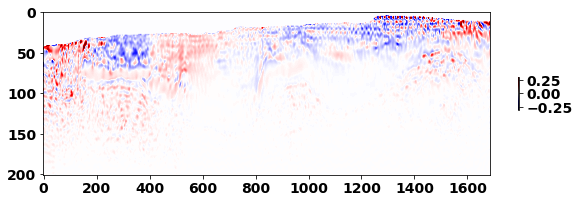

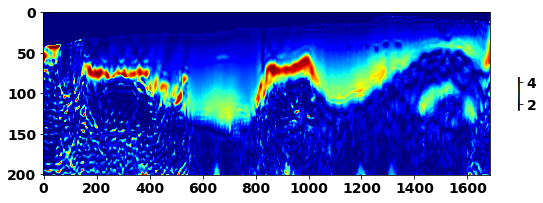

Iteration:  61 Objective:  7.3889153530491e-12
Reduce the smoothing from 0.625,0.9375 to 0.3125,0.46875
Iteration:  62 Objective:  7.382098160839054e-12
Reduce the smoothing from 0.3125,0.46875 to 0.15625,0.234375
Iteration:  63 Objective:  7.37555459415229e-12
Runtime in min : 18.755312295754752


In [14]:



minv,loss = inversion.run_inversion(minit,data_f,wavel_f.repeat(1,ns,1),
            msk,FWI_itr,device,smth_flag=True,smth=[smth1,smth2],vmin=1.5,vmax=4.5,
            tv_flag=TV_FLAG,alphatv=TV_ALPHA,plot_flag=True)

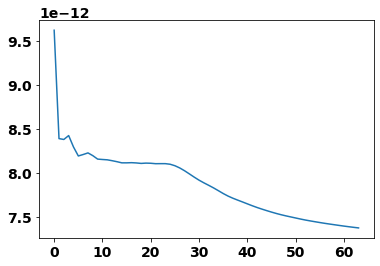

In [15]:
plt.plot(loss)
plt.savefig('loss')

In [16]:
Plot_model(minv[500,],par,vmin=1.5,vmax=4)
Plot_model(minv[-1,],par)

IndexError: index 500 is out of bounds for axis 0 with size 64

In [17]:
save_2drsf(minv[-1,].T,par,output_file)
np.save(output_file,(minv))

echo  ' # This is a Madagascar like header 
 
	 n1=201 
 	 n2=1685 
	 d1=0.02 
 	 d2=0.02 
	 o1=0 
	 o2=0 
	 data_format=native_float 
	 in=./velocity/BPfull_1stinv_TV0_offs6_DomFreq10_MinFreq3_MaxFre7_fwi1_smth10-15temp2@' > ./velocity/BPfull_1stinv_TV0_offs6_DomFreq10_MinFreq3_MaxFre7_fwi1_smth10-15temp2  
        



In [ ]:
minit2  =minv[-1,].copy()

In [ ]:
wavel_f.shape

In [ ]:
minit2 = torch.from_numpy(minit2)